In [1]:
# Chargement Librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, shapiro, kruskal, mannwhitneyu, spearmanr, chi2_contingency
from itertools import combinations

# Sklearn
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.inspection import permutation_importance

import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['font.family'] = 'Futura'

In [2]:
# Chargement
df = pd.read_csv('yulu_bike_sharing_dataset.csv')

print(f"Dataset Shape: {df.shape}")
print(f"\nPremière Lignes:")
display(df.head())
print(f"\nData Types:")
print(df.dtypes)
print(f"\nRésumé Statistiques:")
display(df.describe())

Dataset Shape: (10886, 12)

Première Lignes:


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1



Data Types:
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

Résumé Statistiques:


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [3]:
# Validation

print("Valeurs Manquantes:")
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Pas de Valeurs Manquantes")

print("\nDuplicate Rows:")
print(f"Lignes Dupliquées: {df.duplicated().sum()}")

Valeurs Manquantes:
Pas de Valeurs Manquantes

Duplicate Rows:
Lignes Dupliquées: 0


In [4]:
# Feature Engineering

# Fix Datetime
df['datetime'] = pd.to_datetime(df['datetime'])

# Features Temporelles
df['hour'] = df['datetime'].dt.hour
df['day'] = df['datetime'].dt.day
df['month'] = df['datetime'].dt.month
df['year'] = df['datetime'].dt.year
df['dayofweek'] = df['datetime'].dt.day_name()

# Labels pour Visualisation
df['season_label'] = df['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
df['weather_label'] = df['weather'].map({
    1: 'Clear', 
    2: 'Mist', 
    3: 'Light Rain/Snow', 
    4: 'Heavy Rain/Snow'
})

# Moment de la Journée
df['time_of_day'] = pd.cut(df['hour'], 
                            bins=[0, 6, 12, 18, 24], 
                            labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                            include_lowest=True)

# Autres
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)
df['is_weekend'] = (df['dayofweek'].isin(['Friday', 'Saturday', 'Sunday'])).astype(int)

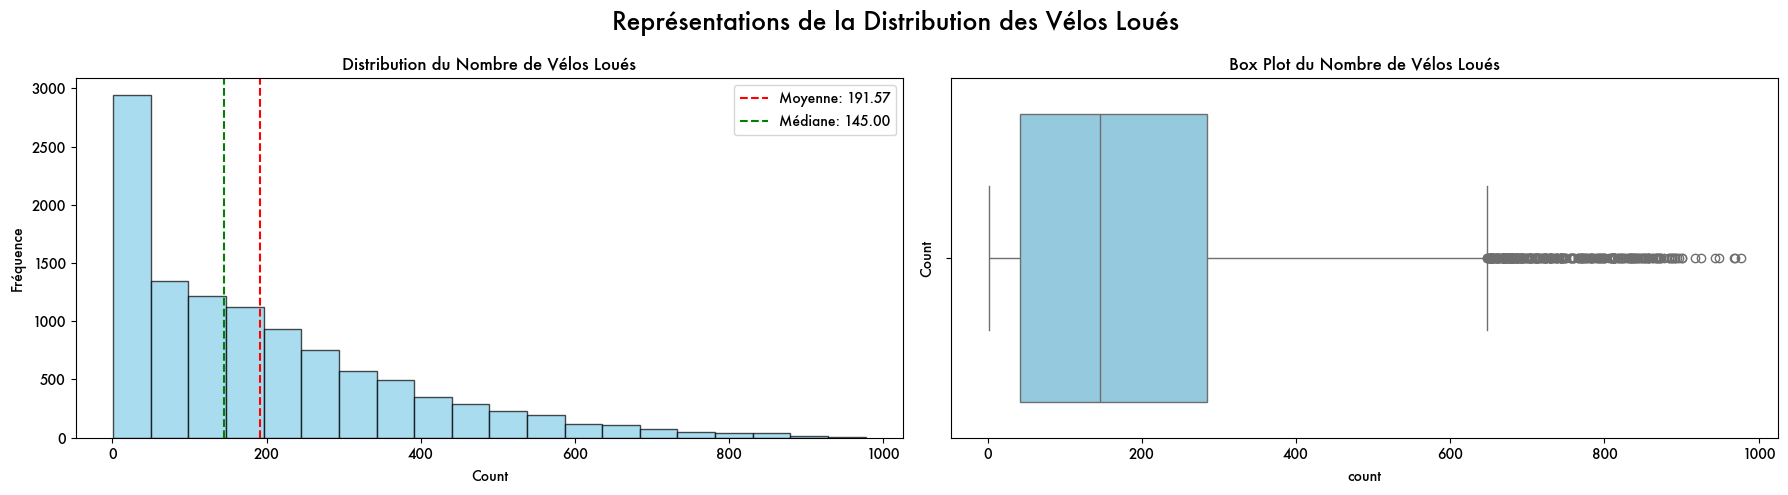

In [5]:
# EDA - Analyse Univariée - Target


fig, axes = plt.subplots(1, 2, figsize=(18, 5))
plt.suptitle('Représentations de la Distribution des Vélos Loués', fontsize=18, fontweight='bold')

# Distribution
axes[0].hist(df['count'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_title('Distribution du Nombre de Vélos Loués', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Fréquence')
axes[0].axvline(df['count'].mean(), color='red', linestyle='--', label=f'Moyenne: {df["count"].mean():.2f}')
axes[0].axvline(df['count'].median(), color='green', linestyle='--', label=f'Médiane: {df["count"].median():.2f}')
axes[0].legend()

# Box plot
sns.boxplot(x=df['count'], ax=axes[1], color='skyblue')
axes[1].set_title('Box Plot du Nombre de Vélos Loués', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count')


plt.tight_layout()
plt.show()

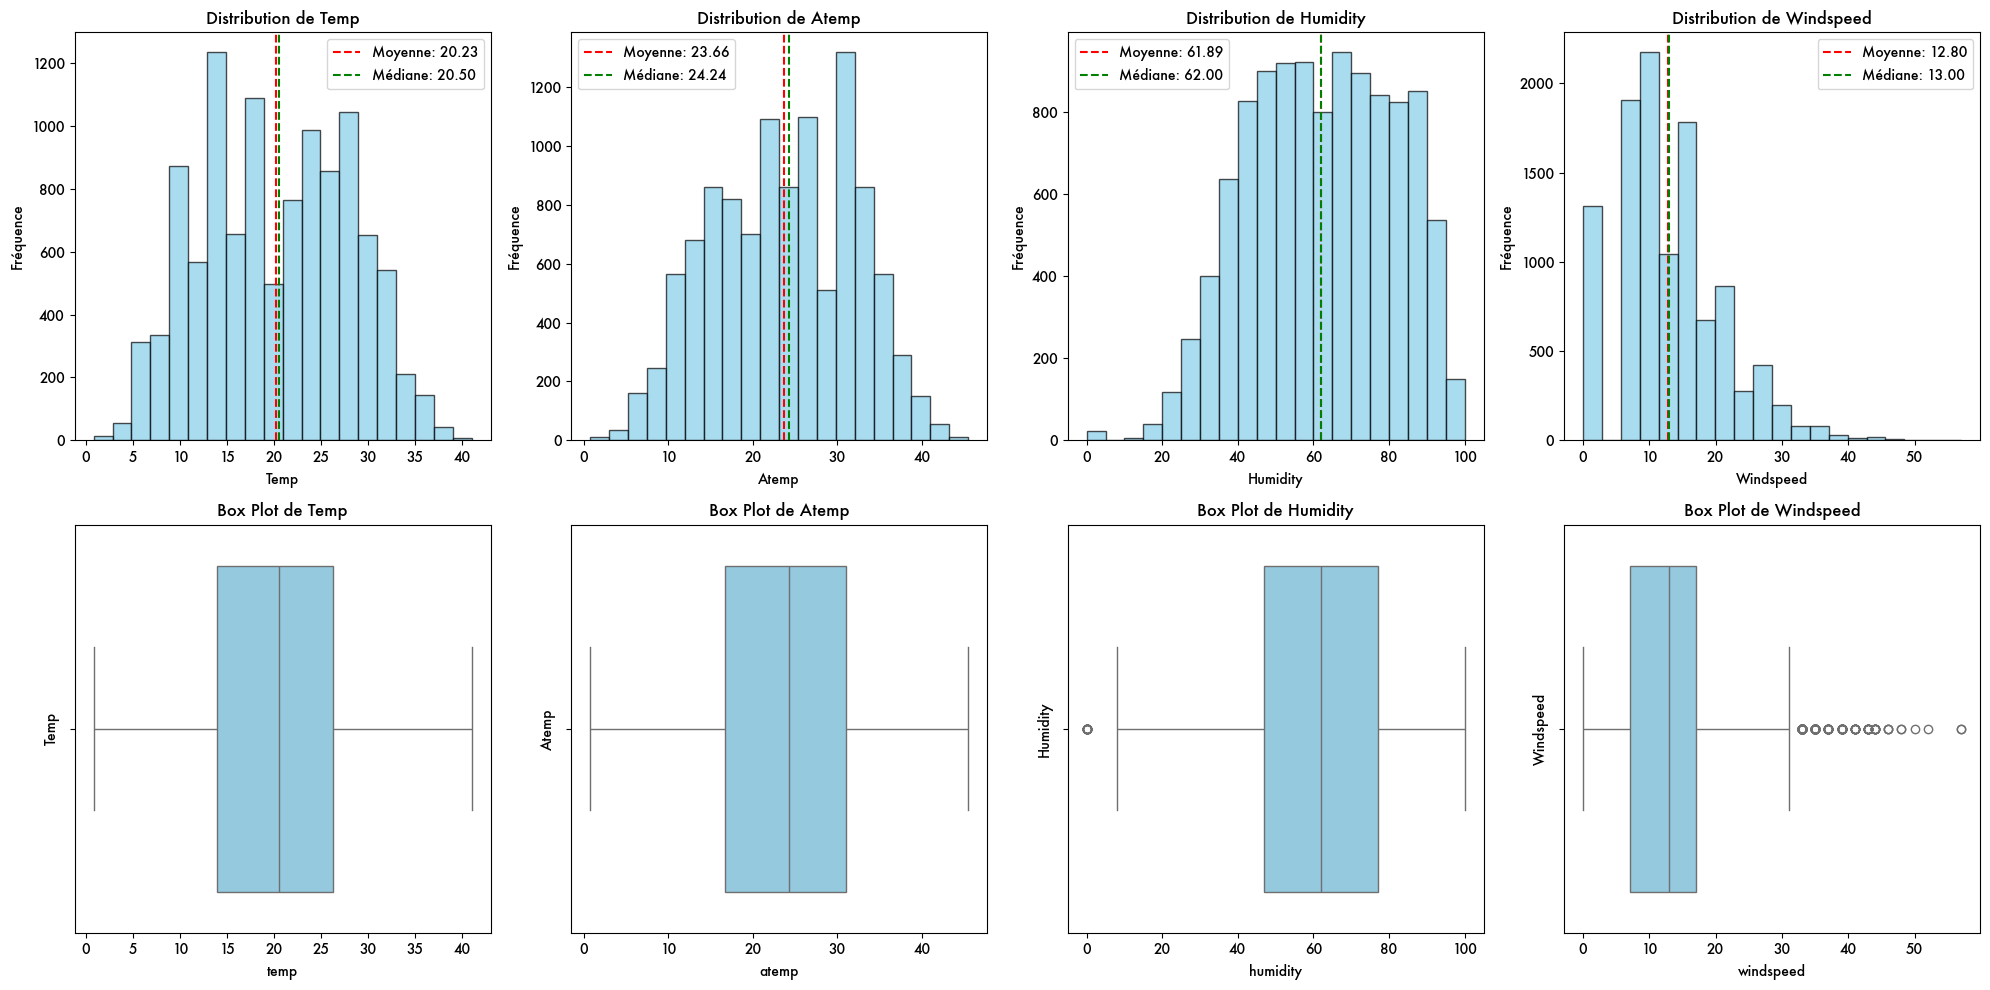

In [6]:
# EDA - Analyse Univariée - Variables Continues

continuous_vars = ['temp', 'atemp', 'humidity', 'windspeed']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, var in enumerate(continuous_vars):
    # Histogramme
    axes[idx].hist(df[var], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution de {var.capitalize()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(var.capitalize())
    axes[idx].set_ylabel('Fréquence')
    axes[idx].axvline(df[var].mean(), color='red', linestyle='--', label=f'Moyenne: {df[var].mean():.2f}')
    axes[idx].axvline(df[var].median(), color='green', linestyle='--', label=f'Médiane: {df[var].median():.2f}')
    axes[idx].legend()
    
    # Box plot
    sns.boxplot(x=df[var], color='skyblue', ax=axes[idx+4])
    axes[idx + 4].set_title(f'Box Plot de {var.capitalize()}', fontsize=12, fontweight='bold')
    axes[idx + 4].set_ylabel(var.capitalize())

plt.tight_layout()
plt.show()

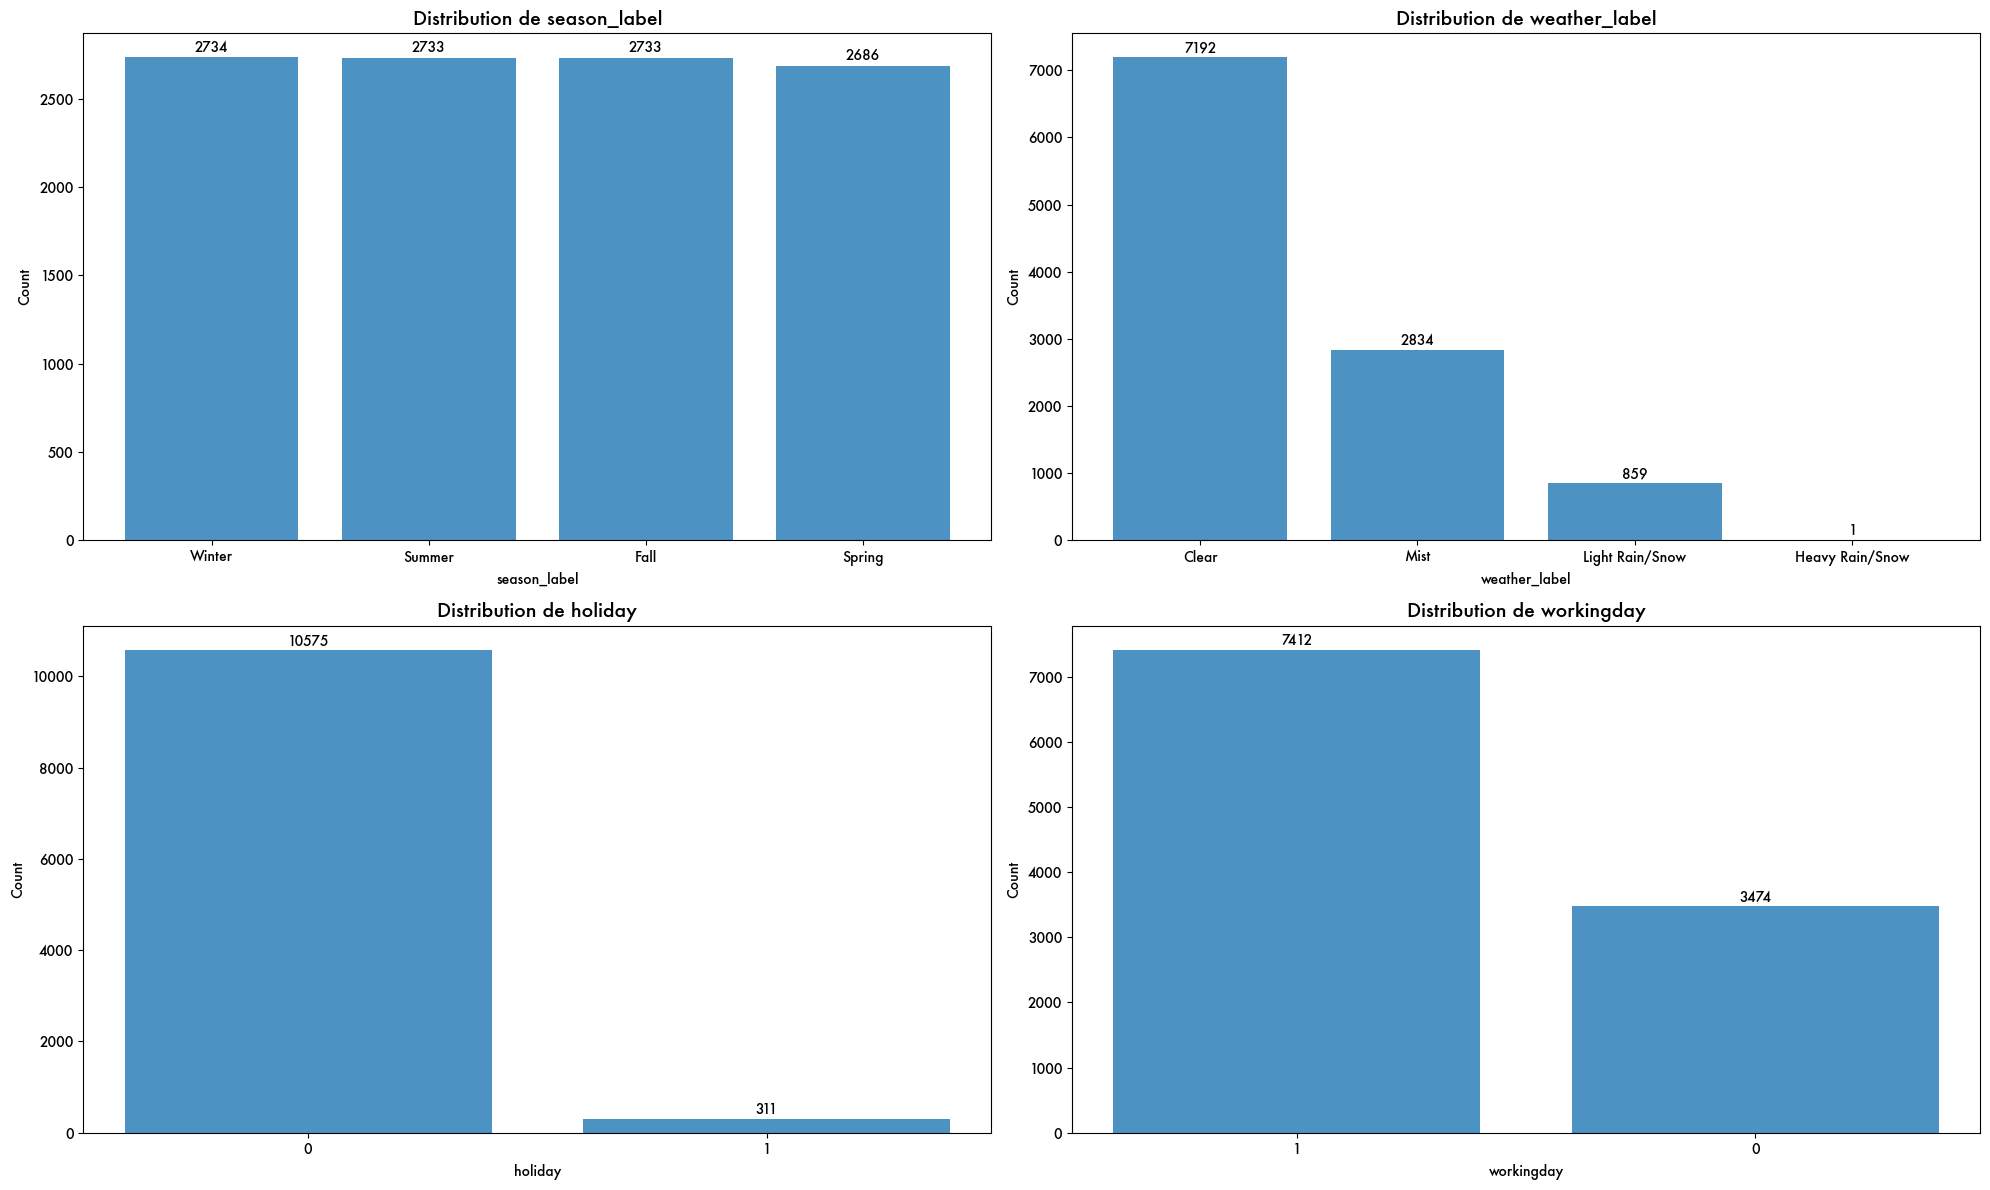

In [7]:
# EDA - Analyse Univariée - Variables Catégorielles

# À METTRE DANS L'ORDRE

categorical_vars = ['season_label', 'weather_label', 'holiday', 'workingday']

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

for idx, var in enumerate(categorical_vars):
    value_counts = df[var].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values, 
                  tick_label=value_counts.index, alpha=0.8)
    axes[idx].set_title(f'Distribution de {var}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Count')
    #axes[idx].tick_params(axis='x', rotation=45)
    
    # Labels
    for i, v in enumerate(value_counts.values):
        axes[idx].text(i, v + 10, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

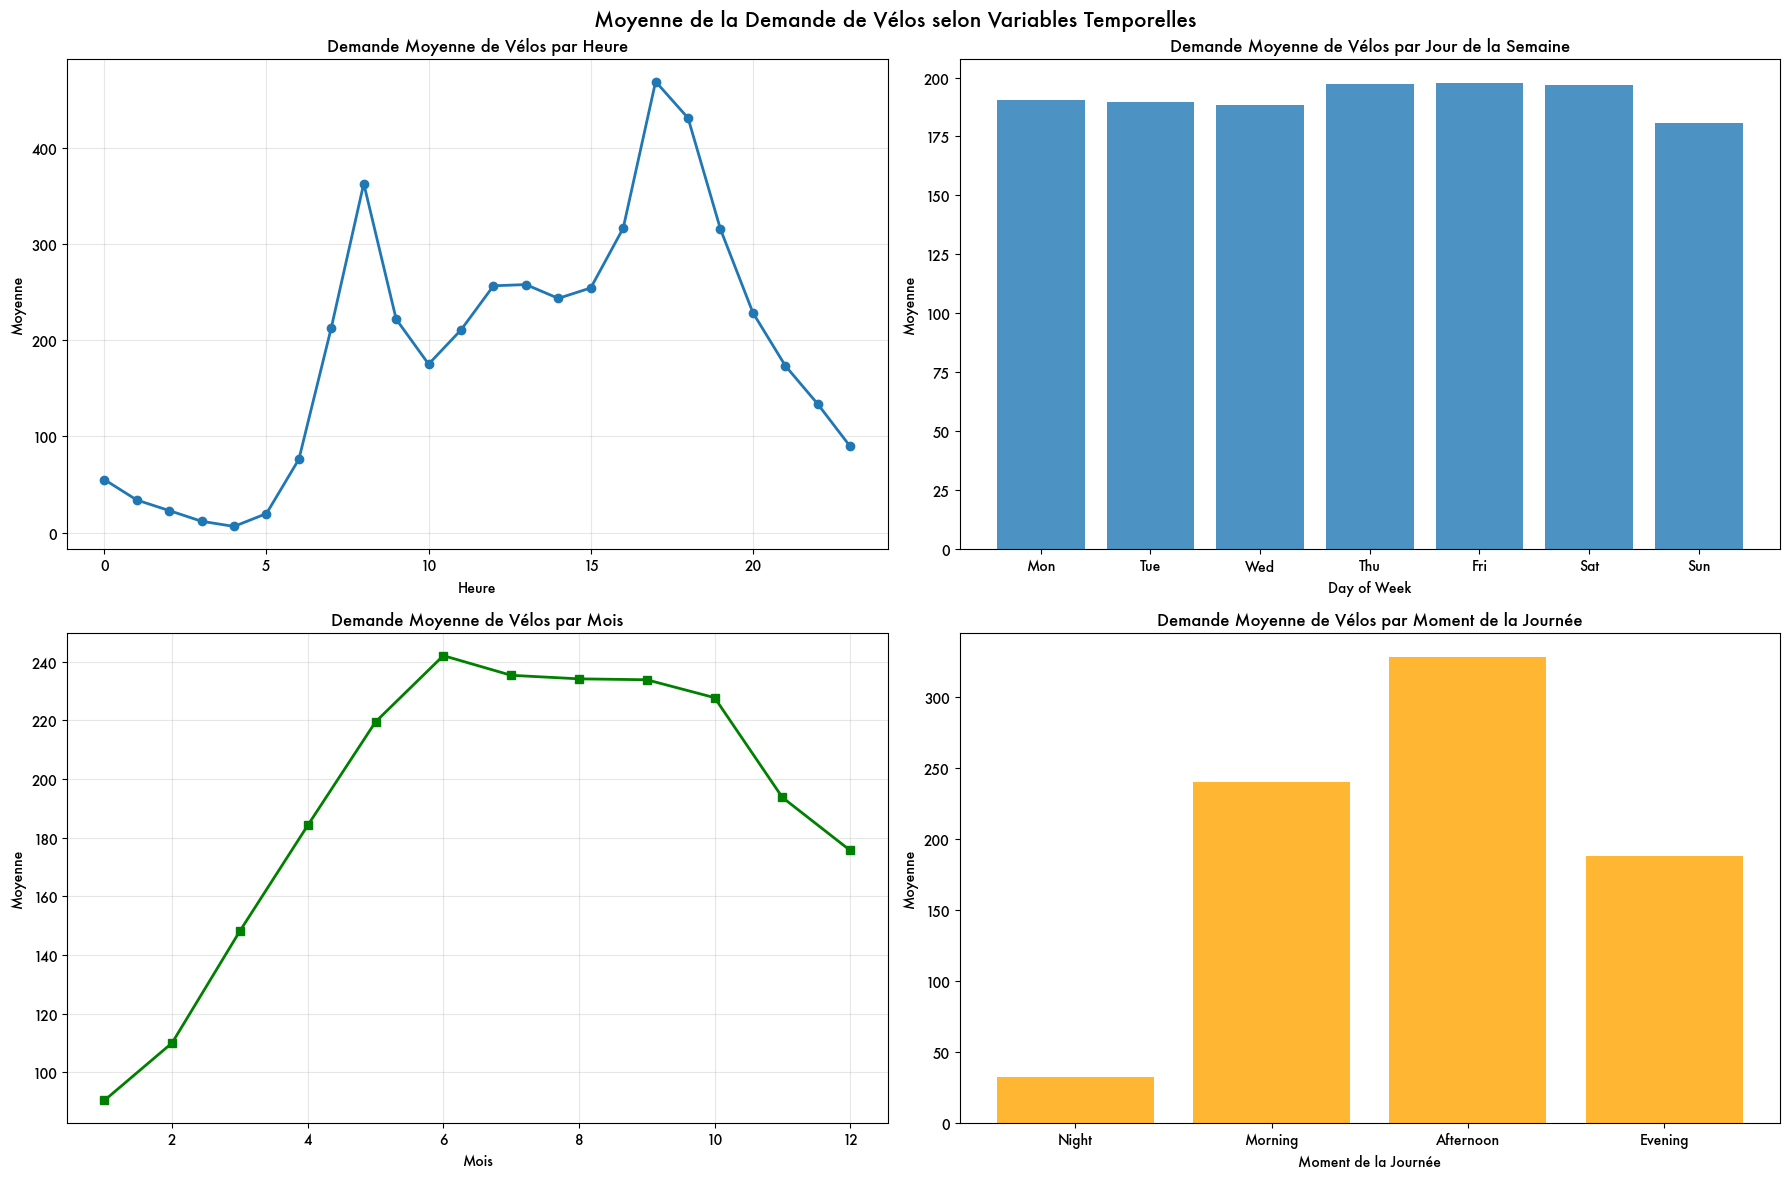

In [8]:
# EDA - Analyse Univariée - Variable Temporelle

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
plt.suptitle('Moyenne de la Demande de Vélos selon Variables Temporelles', fontsize=15, fontweight='bold')

# Heure
hourly_avg = df.groupby('hour')['count'].mean()
axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
axes[0, 0].set_title('Demande Moyenne de Vélos par Heure', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Heure')
axes[0, 0].set_ylabel('Moyenne')
axes[0, 0].grid(True, alpha=0.3)

# Jour
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df.groupby('dayofweek')['count'].mean().reindex(day_order)
day_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0, 1].bar(range(7), daily_avg.values, tick_label=day_labels, alpha=0.8)
axes[0, 1].set_title('Demande Moyenne de Vélos par Jour de la Semaine', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Day of Week')
axes[0, 1].set_ylabel('Moyenne')

# Mois
monthly_avg = df.groupby('month')['count'].mean()
axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='s', linewidth=2, color='green')
axes[1, 0].set_title('Demande Moyenne de Vélos par Mois', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Mois')
axes[1, 0].set_ylabel('Moyenne')
axes[1, 0].grid(True, alpha=0.3)

# Moment de la Journée
time_avg = df.groupby('time_of_day')['count'].mean()
axes[1, 1].bar(range(len(time_avg)), time_avg.values, 
               tick_label=time_avg.index, alpha=0.8, color='orange')
axes[1, 1].set_title('Demande Moyenne de Vélos par Moment de la Journée', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Moment de la Journée')
axes[1, 1].set_ylabel('Moyenne')

plt.tight_layout()
plt.show()

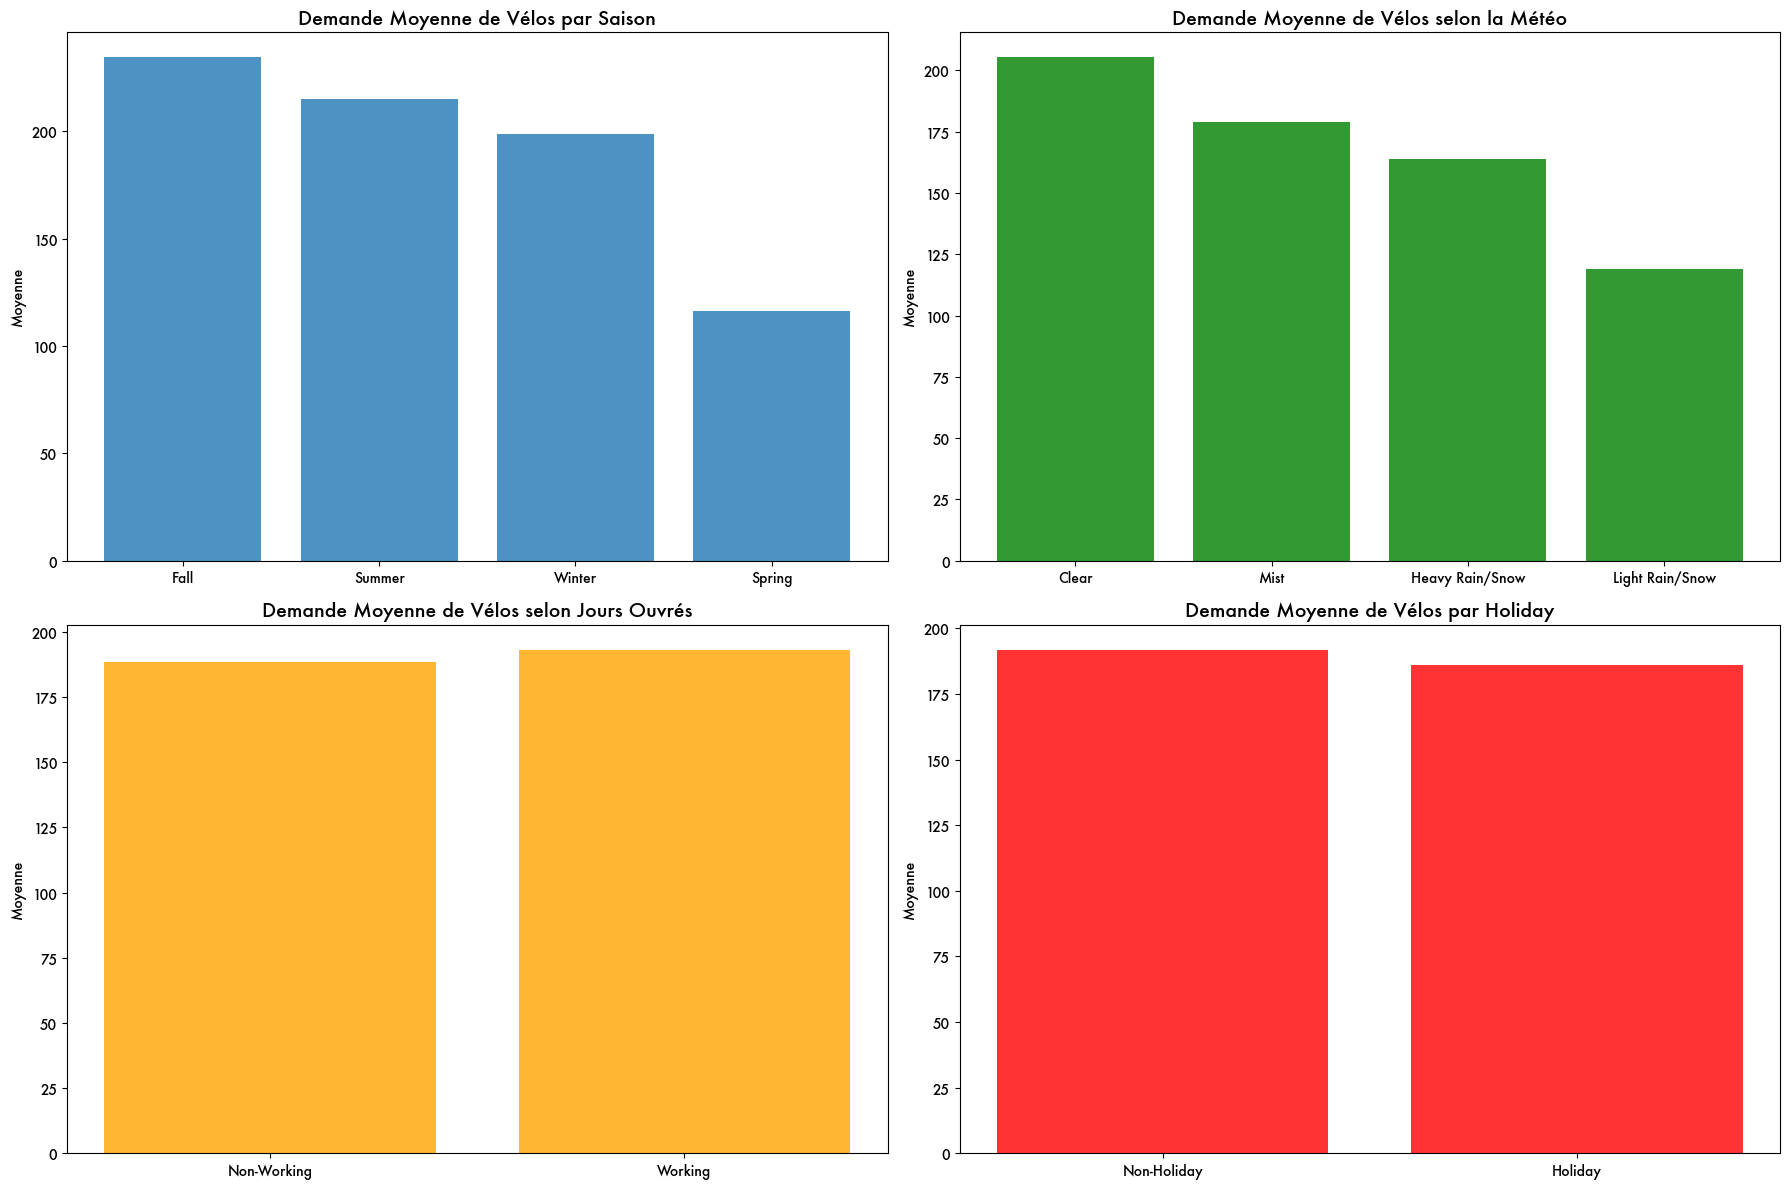

In [9]:
# EDA - Analyse Bivariée - Variables Catégorielles vs Target

fig, axes = plt.subplots(2, 2, figsize=(18, 12))


# Saison
season_avg = df.groupby('season_label')['count'].mean().sort_values(ascending=False)
axes[0, 0].bar(range(len(season_avg)), season_avg.values, 
               tick_label=season_avg.index, alpha=0.8)
axes[0, 0].set_title('Demande Moyenne de Vélos par Saison', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Moyenne')


# Météo
weather_avg = df.groupby('weather_label')['count'].mean().sort_values(ascending=False)
axes[0, 1].bar(range(len(weather_avg)), weather_avg.values, 
               tick_label=weather_avg.index, alpha=0.8, color='green')
axes[0, 1].set_title('Demande Moyenne de Vélos selon la Météo', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Moyenne')


# Jour Ouvré
workday_avg = df.groupby('workingday')['count'].mean()
axes[1, 0].bar([0, 1], workday_avg.values, 
               tick_label=['Non-Working', 'Working'], alpha=0.8, color='orange')
axes[1, 0].set_title('Demande Moyenne de Vélos selon Jours Ouvrés', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Moyenne')

# Holiday
holiday_avg = df.groupby('holiday')['count'].mean()
axes[1, 1].bar([0, 1], holiday_avg.values, 
               tick_label=['Non-Holiday', 'Holiday'], alpha=0.8, color='red')
axes[1, 1].set_title('Demande Moyenne de Vélos par Holiday', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Moyenne')

plt.tight_layout()
plt.show()

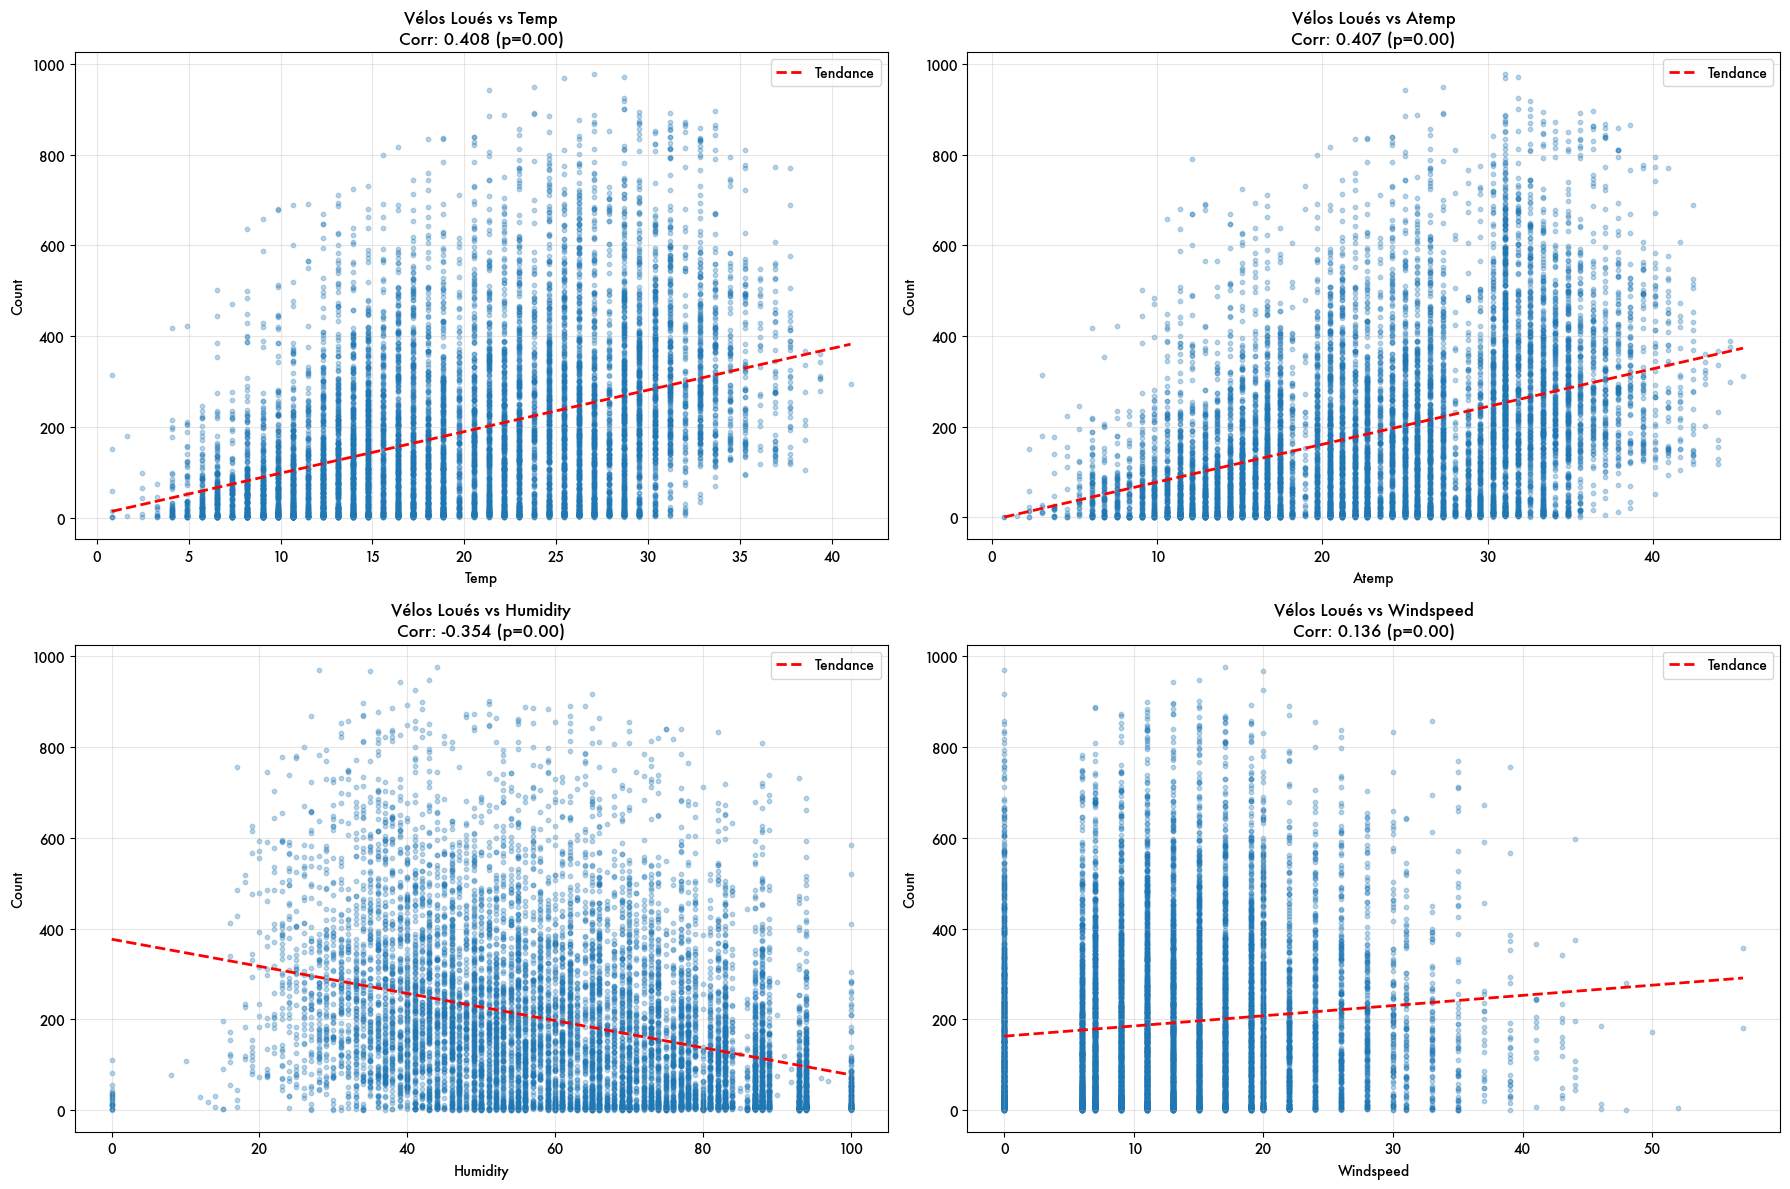

In [10]:
# EDA - Analyse Bivariée - Target vs Continues

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

continuous_vars = ['temp', 'atemp', 'humidity', 'windspeed']

for idx, var in enumerate(continuous_vars):
    # Scatter plot
    axes[idx].scatter(df[var], df['count'], alpha=0.3, s=10)
    
    # Droite
    z = np.polyfit(df[var], df['count'], 1)
    p = np.poly1d(z)
    axes[idx].plot(df[var].sort_values(), p(df[var].sort_values()), 
                   "r--", linewidth=2, label='Tendance')
    
    # Correlation
    corr, p_value = spearmanr(df[var], df['count'])
    
    axes[idx].set_title(f'Vélos Loués vs {var.capitalize()}\nCorr: {corr:.3f} (p={p_value:.2f})', 
                        fontweight='bold')
    axes[idx].set_xlabel(var.capitalize())
    axes[idx].set_ylabel('Count')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

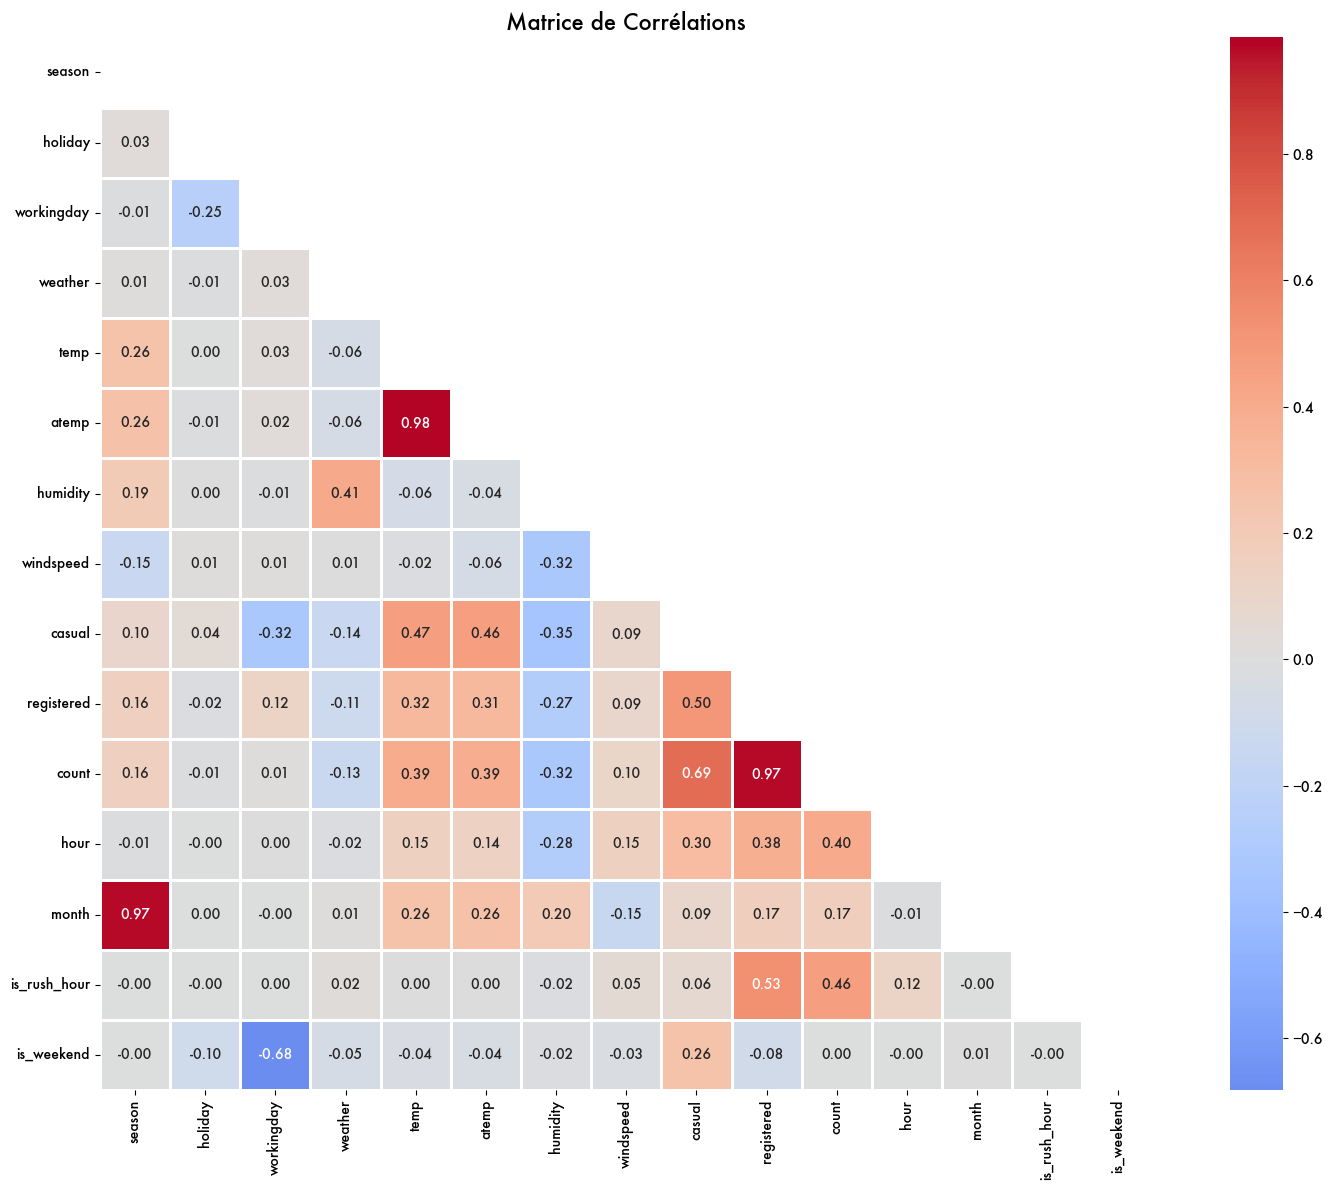

In [11]:
# Matrice de Corrélations

# Colonnes Numériques
numeric_cols = ['season', 'holiday', 'workingday', 'weather', 'temp', 
                'atemp', 'humidity', 'windspeed', 'casual', 'registered', 
                'count', 'hour', 'month', 'is_rush_hour', 'is_weekend']

correlation_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, mask=mask, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Matrice de Corrélations', fontsize=16, fontweight='bold',)
plt.tight_layout()
plt.show()

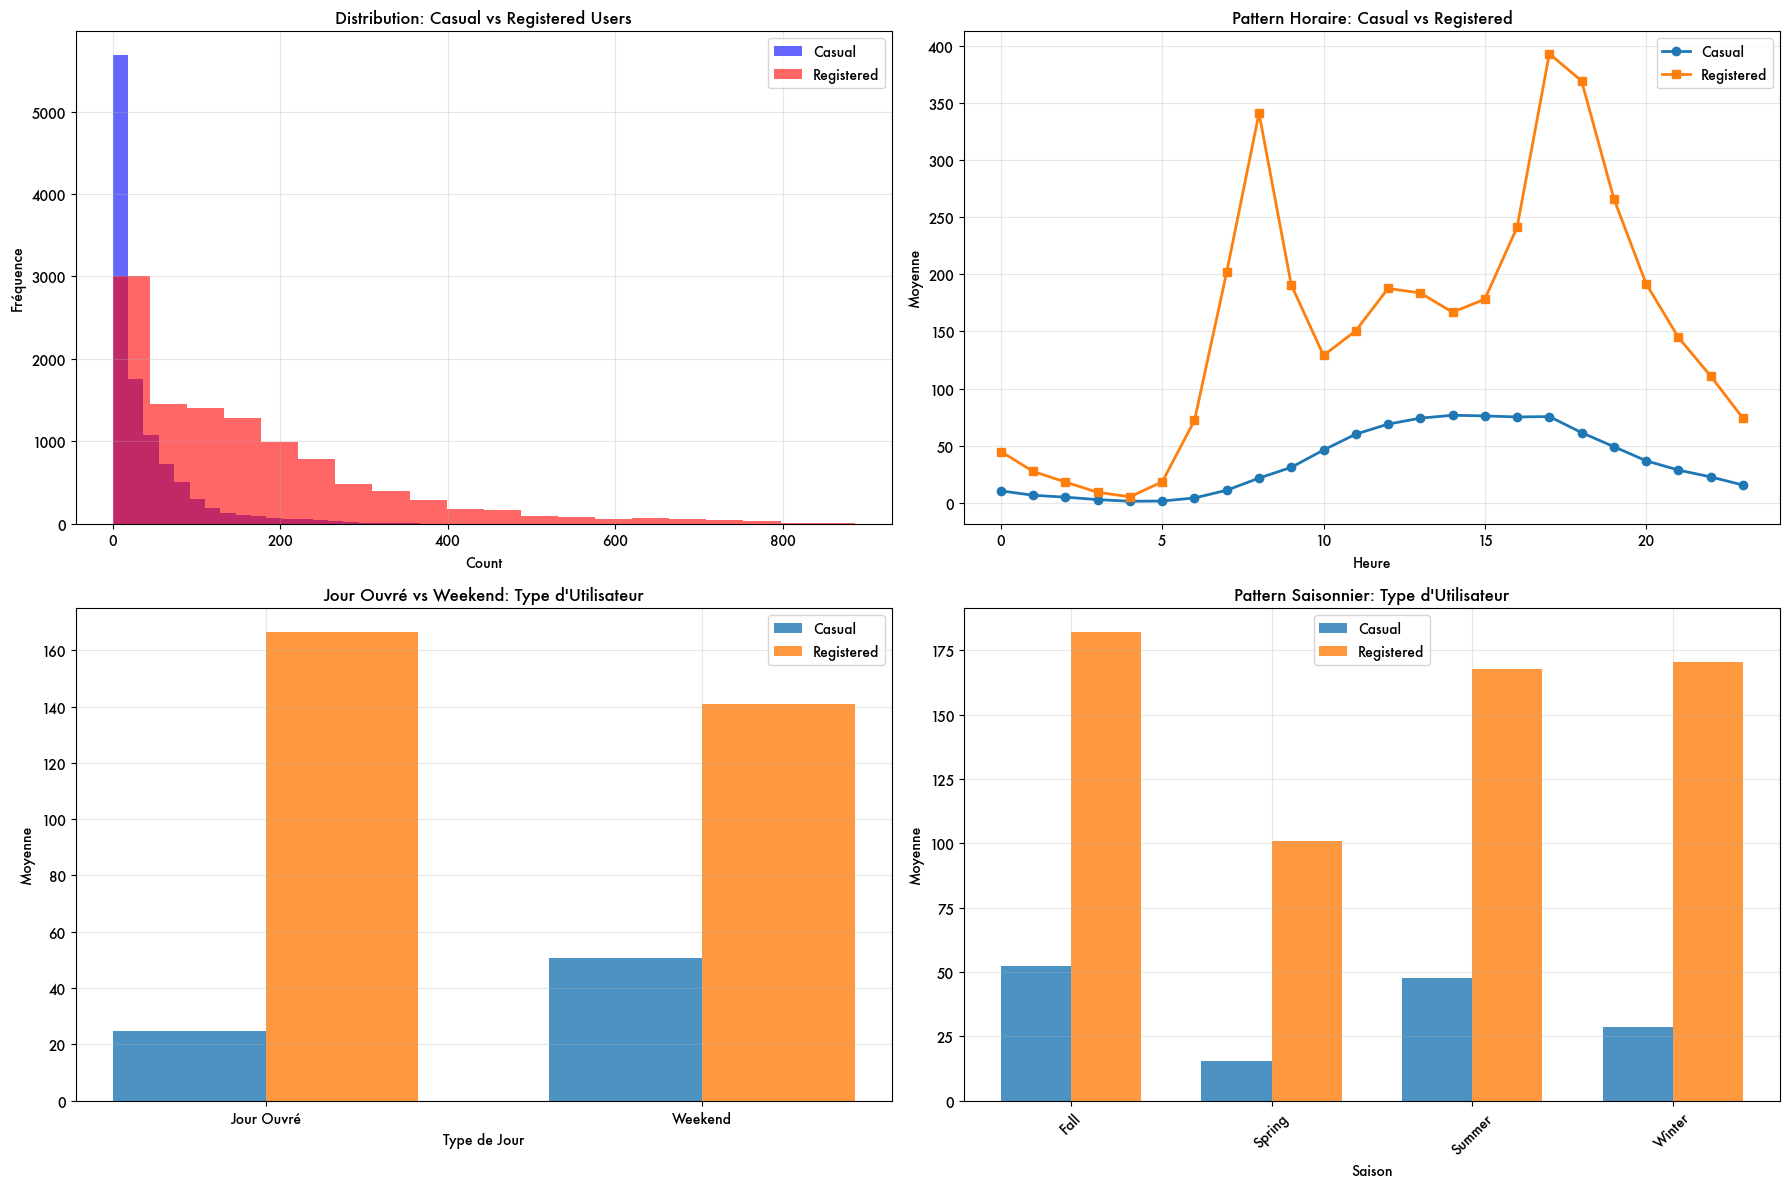

In [12]:
# Analyse Type d'utilisateur

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Distribution
axes[0, 0].hist(df['casual'], bins=20, alpha=0.6, label='Casual', color='blue')
axes[0, 0].hist(df['registered'], bins=20, alpha=0.6, label='Registered', color='red')
axes[0, 0].set_title('Distribution: Casual vs Registered Users', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Count')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
# Pattern Horaire
hourly_casual = df.groupby('hour')['casual'].mean()
hourly_registered = df.groupby('hour')['registered'].mean()
axes[0, 1].plot(hourly_casual.index, hourly_casual.values, marker='o', label='Casual', linewidth=2)
axes[0, 1].plot(hourly_registered.index, hourly_registered.values, marker='s', label='Registered', linewidth=2)
axes[0, 1].set_title('Pattern Horaire: Casual vs Registered', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Heure')
axes[0, 1].set_ylabel('Moyenne')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Jour Ouvré vs Weekend
weekday_casual = df.groupby('is_weekend')['casual'].mean()
weekday_registered = df.groupby('is_weekend')['registered'].mean()
x = [0, 1]
width = 0.35
axes[1, 0].bar([i - width/2 for i in x], weekday_casual.values, width, label='Casual', alpha=0.8)
axes[1, 0].bar([i + width/2 for i in x], weekday_registered.values, width, label='Registered', alpha=0.8)
axes[1, 0].set_title('Jour Ouvré vs Weekend: Type d\'Utilisateur', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Type de Jour')
axes[1, 0].set_ylabel('Moyenne')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['Jour Ouvré', 'Weekend'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Pattern Saisonnier
season_casual = df.groupby('season_label')['casual'].mean()
season_registered = df.groupby('season_label')['registered'].mean()
x_pos = range(len(season_casual))
axes[1, 1].bar([i - width/2 for i in x_pos], season_casual.values, width, label='Casual', alpha=0.8)
axes[1, 1].bar([i + width/2 for i in x_pos], season_registered.values, width, label='Registered', alpha=0.8)
axes[1, 1].set_title('Pattern Saisonnier: Type d\'Utilisateur', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Saison')
axes[1, 1].set_ylabel('Moyenne')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(season_casual.index, rotation=45)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

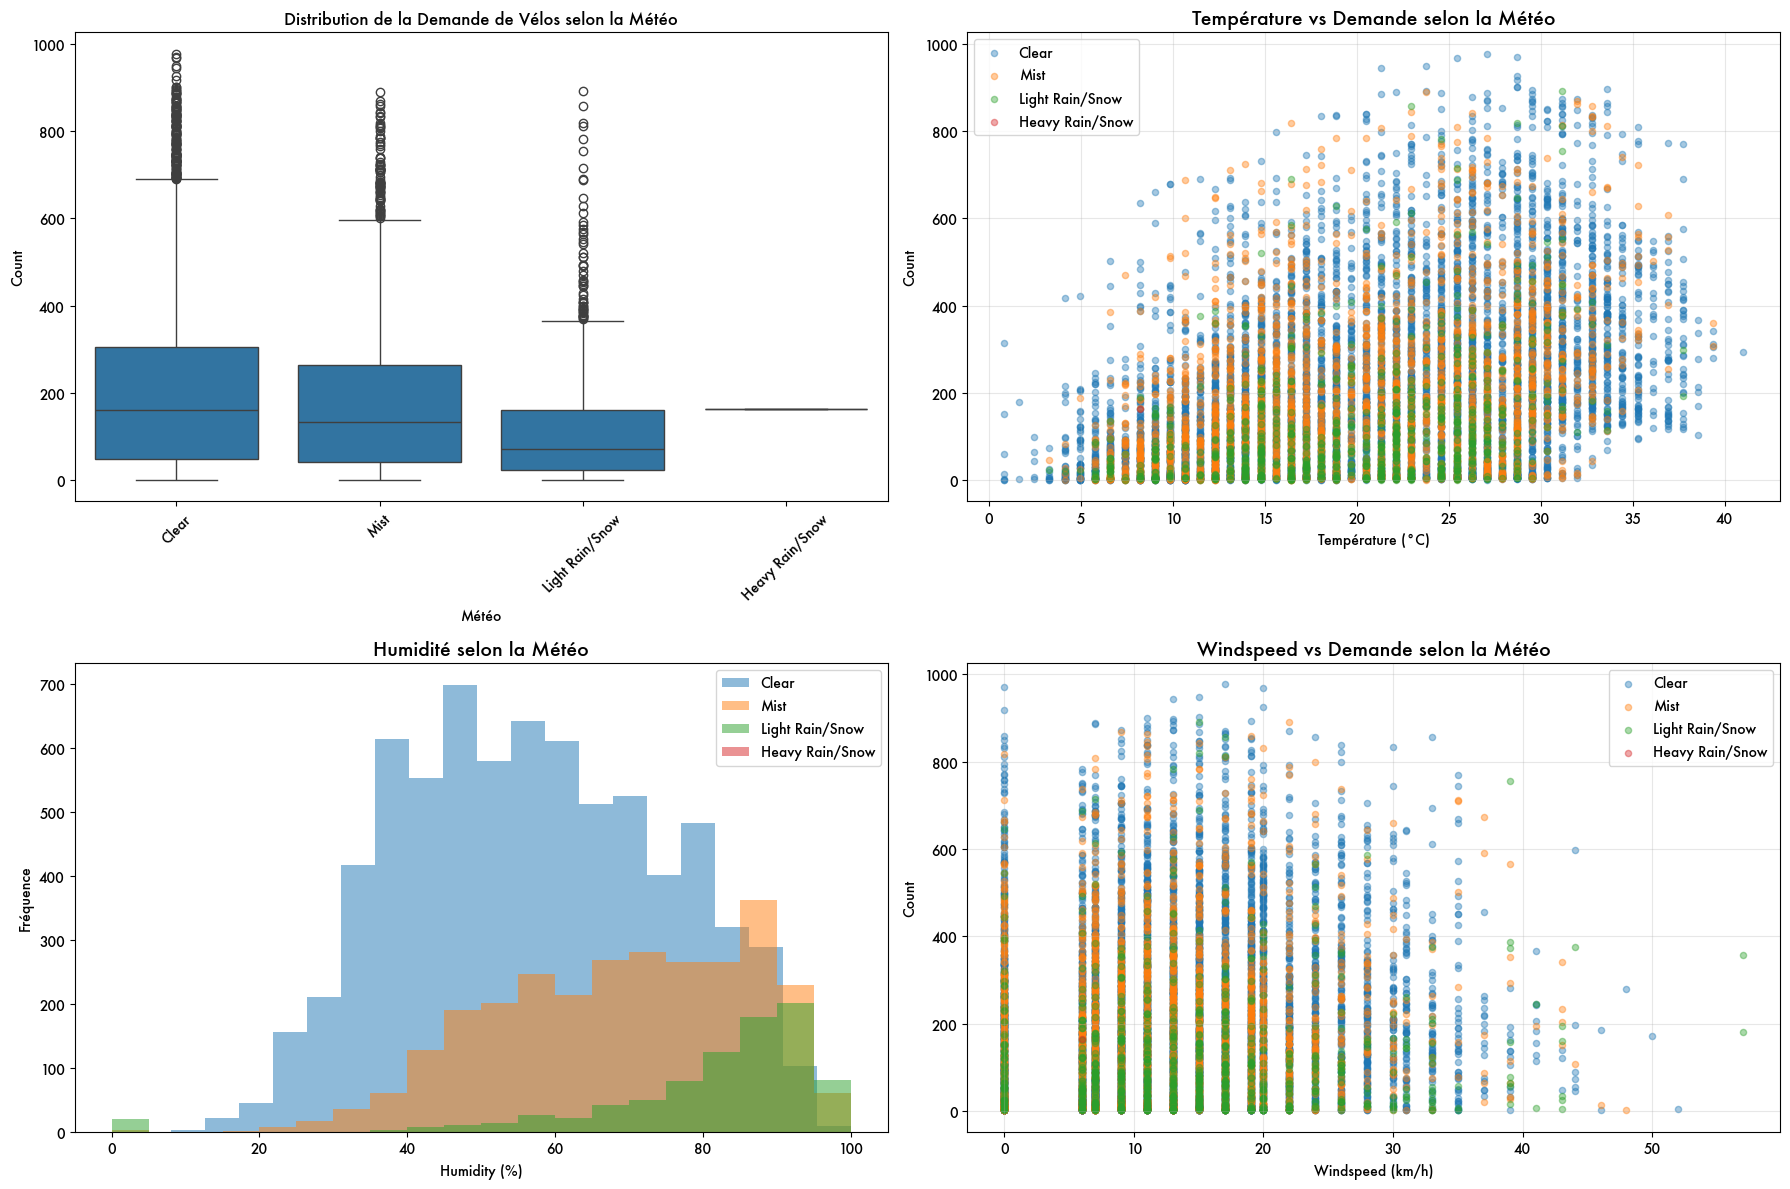

In [13]:
# Impact de la Météo

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Météo vs Count 
weather_order = ['Clear', 'Mist', 'Light Rain/Snow', 'Heavy Rain/Snow']
sns.boxplot(data=df, x='weather_label', y='count', order=weather_order, ax=axes[0, 0])
axes[0, 0].set_title('Distribution de la Demande de Vélos selon la Météo', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Météo')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# Temperature vs Count selon la Météo
for weather in df['weather_label'].unique():
    weather_data = df[df['weather_label'] == weather]
    axes[0, 1].scatter(weather_data['temp'], weather_data['count'], 
                       alpha=0.4, label=weather, s=20)
axes[0, 1].set_title('Température vs Demande selon la Météo', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Température (°C)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Humidité selon la Météo
for weather in weather_order:
    if weather in df['weather_label'].values:
        axes[1, 0].hist(df[df['weather_label'] == weather]['humidity'], 
                        bins=20, alpha=0.5, label=weather)
axes[1, 0].set_title('Humidité selon la Météo', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Humidity (%)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].legend()

# Windspeed selon la Météo
for weather in df['weather_label'].unique():
    weather_data = df[df['weather_label'] == weather]
    axes[1, 1].scatter(weather_data['windspeed'], weather_data['count'], 
                       alpha=0.4, label=weather, s=20)
axes[1, 1].set_title('Windspeed vs Demande selon la Météo', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Windspeed (km/h)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
# Tests de Normalité

# Test target variable (using sample for Shapiro-Wilk)
stat_shapiro, p_shapiro = shapiro(df['count'][:5000])
print(f"Test de Shapiro-Wilk pour 'count' :")
print(f"  Statistique : {stat_shapiro:.6f}")
print(f"  P-value : {p_shapiro:.6f}")
print(f"  Résultat : {'Les données NE suivent PAS une loi normale' if p_shapiro < 0.05 else 'Les données suivent une loi normale'}")

# Test continuous variables
print("\nTests de normalité pour les variables continues :")
print("-" * 80)
continuous_vars = ['temp', 'atemp', 'humidity', 'windspeed']
all_normal = True

for var in continuous_vars:
    stat, p_value = normaltest(df[var])
    is_normal = p_value >= 0.05
    all_normal = all_normal and is_normal
    print(f"{var.capitalize():15s} : p-value={p_value:.6f} => {'Normale' if is_normal else 'NON normale'}")

print(f"\n{'='*80}")
print(f"CONCLUSION : Les données sont {'NORMALES' if all_normal else 'NON NORMALES'}")
print(f"→ Utiliser des tests {'PARAMÉTRIQUES' if all_normal else 'NON PARAMÉTRIQUES'}")
print(f"{'='*80}")

Test de Shapiro-Wilk pour 'count' :
  Statistique : 0.884461
  P-value : 0.000000
  Résultat : Les données NE suivent PAS une loi normale

Tests de normalité pour les variables continues :
--------------------------------------------------------------------------------
Temp            : p-value=0.000000 => NON normale
Atemp           : p-value=0.000000 => NON normale
Humidity        : p-value=0.000000 => NON normale
Windspeed       : p-value=0.000000 => NON normale

CONCLUSION : Les données sont NON NORMALES
→ Utiliser des tests NON PARAMÉTRIQUES


In [15]:
print("\n" + "="*80)
print("TEST D’HYPOTHÈSE 1 : EFFET DE LA SAISON")
print("="*80)

print("\nH0 : La demande moyenne de vélos est identique pour toutes les saisons")
print("H1 : Au moins une saison a une demande moyenne différente")

season_groups = [df[df['season'] == i]['count'].values for i in range(1, 5)]

# Test de Kruskal-Wallis
stat_kw, p_kw = kruskal(*season_groups)

print(f"\nTest de Kruskal-Wallis (non paramétrique) :")
print(f"  Statistique H : {stat_kw:.4f}")
print(f"  P-value : {p_kw:.10f}")

if p_kw < 0.05:
    print(f"  ✓ REJET DE H0 (p={p_kw:.6f} < 0.05)")
    print(f"  ✓ La saison a un EFFET SIGNIFICATIF sur la demande de vélos")
else:
    print(f"  ✗ NON-REJET DE H0 (p={p_kw:.6f} >= 0.05)")
    print(f"  ✗ La saison n’a PAS d’effet significatif")

# Taille de l’effet
print("\n" + "-"*80)
print("ANALYSE DE LA TAILLE DE L’EFFET :")
print("-"*80)

n = len(df)
k = len(season_groups)
epsilon_squared = (stat_kw - k + 1) / (n - k)

print(f"\nEpsilon-carré (ε²) : {epsilon_squared:.4f}")
print(f"  Proportion de variance expliquée par la saison : {epsilon_squared*100:.2f}%")
print(f"  Interprétation : ", end="")
if epsilon_squared < 0.01:
    effect_label = "FAIBLE"
    print(f"Effet {effect_label.lower()} (ε² < 0.01)")
elif epsilon_squared < 0.06:
    effect_label = "MOYEN"
    print(f"Effet {effect_label.lower()} (0.01 ≤ ε² < 0.06)")
else:
    effect_label = "FORT"
    print(f"Effet {effect_label.lower()} (ε² ≥ 0.06)")

# Statistiques descriptives par saison
print("\n" + "-"*80)
print("Statistiques descriptives par saison :")
season_stats = df.groupby('season_label')['count'].agg(['mean', 'median', 'std', 'count'])
print(season_stats)

# TEST POST-HOC : Mann-Whitney U par paires avec correction de Bonferroni
if p_kw < 0.05:
    print("\n" + "-" * 80)
    print("TEST POST-HOC : Comparaisons par paires avec correction de Bonferroni")
    print("-" * 80)
    
    seasons = [1, 2, 3, 4]
    season_names = {1: 'Printemps', 2: 'Été', 3: 'Automne', 4: 'Hiver'}
    
    n_comparisons = len(list(combinations(seasons, 2)))
    alpha_corrected = 0.05 / n_comparisons
    
    print(f"Nombre de comparaisons par paires : {n_comparisons}")
    print(f"Alpha corrigé (Bonferroni) : {alpha_corrected:.4f}")
    print("\nComparaisons par paires avec tailles d’effet :")
    print(f"{'Comparaison':<20} {'Stat U':<12} {'P-value':<12} {'Sig. ?':<8} {'d de Cohen':<12}")
    print("-" * 80)
    
    def cohen_d(group1, group2):
        n1, n2 = len(group1), len(group2)
        var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
        d = (np.mean(group1) - np.mean(group2)) / pooled_std
        return d
    
    significant_pairs = []
    for s1, s2 in combinations(seasons, 2):
        group1 = df[df['season'] == s1]['count'].values
        group2 = df[df['season'] == s2]['count'].values
        
        u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
        is_sig = "OUI ✓" if p_val < alpha_corrected else "Non"
        
        d = cohen_d(group1, group2)
        
        comparison = f"{season_names[s1]} vs {season_names[s2]}"
        print(f"{comparison:<20} {u_stat:<12.2f} {p_val:<12.6f} {is_sig:<8} {d:<12.4f}")
        
        if p_val < alpha_corrected:
            mean1 = df[df['season'] == s1]['count'].mean()
            mean2 = df[df['season'] == s2]['count'].mean()
            higher = season_names[s1] if mean1 > mean2 else season_names[s2]
            significant_pairs.append((comparison, higher, d))
    
    if significant_pairs:
        print("\n" + "-" * 80)
        print("DIFFÉRENCES SIGNIFICATIVES :")
        for pair, higher, d in significant_pairs:
            print(f"  • {pair} : {higher} a une demande significativement plus élevée (d={d:.4f})")
    else:
        print("\nAucune différence significative après correction de Bonferroni")

# Interprétation métier
print("\n" + "="*80)
print("INTERPRÉTATION :")
print("="*80)
print(f"Significativité statistique : p = {p_kw:.6f} {'✓ Significatif' if p_kw < 0.05 else '✗ Non Significatif'}")
print(f"Taille de l’effet : ε² = {epsilon_squared:.4f} ({effect_label}) {'✓' if epsilon_squared >= 0.01 else '⚠'}")
print(f"→ La saison explique {epsilon_squared*100:.1f}% de la variance de la demande")
if p_kw < 0.05 and epsilon_squared >= 0.01:
    print(f"→ Il s’agit d’un effet {effect_label.lower()} et SIGNIFICATIF pour les décisions métier")
else:
    print(f"→ Effet statistiquement significatif mais peut ne pas être pertinent en pratique")


TEST D’HYPOTHÈSE 1 : EFFET DE LA SAISON

H0 : La demande moyenne de vélos est identique pour toutes les saisons
H1 : Au moins une saison a une demande moyenne différente

Test de Kruskal-Wallis (non paramétrique) :
  Statistique H : 699.6669
  P-value : 0.0000000000
  ✓ REJET DE H0 (p=0.000000 < 0.05)
  ✓ La saison a un EFFET SIGNIFICATIF sur la demande de vélos

--------------------------------------------------------------------------------
ANALYSE DE LA TAILLE DE L’EFFET :
--------------------------------------------------------------------------------

Epsilon-carré (ε²) : 0.0640
  Proportion de variance expliquée par la saison : 6.40%
  Interprétation : Effet fort (ε² ≥ 0.06)

--------------------------------------------------------------------------------
Statistiques descriptives par saison :
                    mean  median         std  count
season_label                                       
Fall          234.417124   195.0  197.151001   2733
Spring        116.343261    78.0

In [16]:
print("\n" + "="*80)
print("TEST D’HYPOTHÈSE 2 : EFFET DE LA MÉTÉO")
print("="*80)

print("\nH0 : La demande moyenne de vélos est identique pour toutes les conditions météo")
print("H1 : Au moins une condition météo a une demande moyenne différente")

weather_groups = [df[df['weather'] == i]['count'].values for i in df['weather'].unique()]

stat_kw_weather, p_kw_weather = kruskal(*weather_groups)

print(f"\nTest de Kruskal-Wallis (non paramétrique) :")
print(f"  Statistique H : {stat_kw_weather:.4f}")
print(f"  P-value : {p_kw_weather:.10f}")

if p_kw_weather < 0.05:
    print(f"  ✓ REJET DE H0 (p={p_kw_weather:.6f} < 0.05)")
    print(f"  ✓ La météo a un EFFET SIGNIFICATIF sur la demande de vélos")
else:
    print(f"  ✗ NON-REJET DE H0 (p={p_kw_weather:.6f} >= 0.05)")
    print(f"  ✗ La météo n’a PAS d’effet significatif")

# Taille de l’effet
print("\n" + "-"*80)
print("ANALYSE DE LA TAILLE DE L’EFFET :")
print("-"*80)

n_weather = len(df)
k_weather = len(weather_groups)
epsilon_squared_weather = (stat_kw_weather - k_weather + 1) / (n_weather - k_weather)

print(f"\nEpsilon-carré (ε²) : {epsilon_squared_weather:.4f}")
print(f"  Proportion de variance expliquée par la météo : {epsilon_squared_weather*100:.2f}%")
print(f"  Interprétation : ", end="")
if epsilon_squared_weather < 0.01:
    effect_label_weather = "FAIBLE"
    print(f"Effet {effect_label_weather.lower()} (ε² < 0.01)")
elif epsilon_squared_weather < 0.06:
    effect_label_weather = "MOYEN"
    print(f"Effet {effect_label_weather.lower()} (0.01 ≤ ε² < 0.06)")
else:
    effect_label_weather = "FORT"
    print(f"Effet {effect_label_weather.lower()} (ε² ≥ 0.06)")

# Statistiques descriptives par météo
print("\n" + "-"*80)
print("Statistiques descriptives par condition météo :")
weather_stats = df.groupby('weather_label')['count'].agg(['mean', 'median', 'std', 'count'])
print(weather_stats)

# TEST POST-HOC
if p_kw_weather < 0.05:
    print("\n" + "-" * 80)
    print("TEST POST-HOC : Comparaisons par paires avec correction de Bonferroni")
    print("-" * 80)
    
    weathers = sorted(df['weather'].unique())
    weather_names = {1: 'Clair', 2: 'Brume', 3: 'Pluie/Neige légère', 4: 'Pluie/Neige forte'}
    
    n_comparisons_weather = len(list(combinations(weathers, 2)))
    alpha_corrected_weather = 0.05 / n_comparisons_weather
    
    print(f"Nombre de comparaisons par paires : {n_comparisons_weather}")
    print(f"Alpha corrigé (Bonferroni) : {alpha_corrected_weather:.4f}")
    print("\nComparaisons par paires :")
    print(f"{'Comparaison':<40} {'Stat U':<12} {'P-value':<12} {'Sig. ?':<8} {'d de Cohen':<12}")
    print("-" * 80)
    
    significant_pairs_weather = []
    for w1, w2 in combinations(weathers, 2):
        group1 = df[df['weather'] == w1]['count'].values
        group2 = df[df['weather'] == w2]['count'].values
        u_stat, p_val = mannwhitneyu(group1, group2, alternative='two-sided')
        is_sig = "OUI ✓" if p_val < alpha_corrected_weather else "Non"

        d = cohen_d(group1, group2)
        
        comparison = f"{weather_names[w1]} vs {weather_names[w2]}"
        print(f"{comparison:<40} {u_stat:<12.2f} {p_val:<12.6f} {is_sig:<8} {d:<12.4f}")
        
        if p_val < alpha_corrected_weather:
            mean1 = df[df['weather'] == w1]['count'].mean()
            mean2 = df[df['weather'] == w2]['count'].mean()
            higher = weather_names[w1] if mean1 > mean2 else weather_names[w2]
            significant_pairs_weather.append((comparison, higher, d))
    
    if significant_pairs_weather:
        print("\n" + "-" * 80)
        print("DIFFÉRENCES SIGNIFICATIVES :")
        for pair, higher, d in significant_pairs_weather:
            print(f"  • {pair} : {higher} a une demande significativement plus élevée (d={d:.4f})")
    else:
        print("\nAucune différence significative après correction de Bonferroni")

# Interprétation métier
print("\n" + "="*80)
print("INTERPRÉTATION :")
print("="*80)
print(f"Significativité statistique : p = {p_kw_weather:.6f} {'✓ Significatif' if p_kw_weather < 0.05 else '✗ Non Significatif'}")
print(f"Taille de l’effet : ε² = {epsilon_squared_weather:.4f} ({effect_label_weather}) {'✓' if epsilon_squared_weather >= 0.01 else '⚠'}")
print(f"→ La météo explique {epsilon_squared_weather*100:.1f}% de la variance de la demande")


TEST D’HYPOTHÈSE 2 : EFFET DE LA MÉTÉO

H0 : La demande moyenne de vélos est identique pour toutes les conditions météo
H1 : Au moins une condition météo a une demande moyenne différente

Test de Kruskal-Wallis (non paramétrique) :
  Statistique H : 205.0022
  P-value : 0.0000000000
  ✓ REJET DE H0 (p=0.000000 < 0.05)
  ✓ La météo a un EFFET SIGNIFICATIF sur la demande de vélos

--------------------------------------------------------------------------------
ANALYSE DE LA TAILLE DE L’EFFET :
--------------------------------------------------------------------------------

Epsilon-carré (ε²) : 0.0186
  Proportion de variance expliquée par la météo : 1.86%
  Interprétation : Effet moyen (0.01 ≤ ε² < 0.06)

--------------------------------------------------------------------------------
Statistiques descriptives par condition météo :
                       mean  median         std  count
weather_label                                         
Clear            205.236791   161.0  187.95956

In [17]:
print("\n" + "="*80)
print("TEST D’HYPOTHÈSE 3 : EFFET DU JOUR OUVRABLE")
print("="*80)

print("\nH0 : La demande moyenne de vélos est identique pour les jours ouvrables et non ouvrables")
print("H1 : La demande moyenne diffère entre jours ouvrables et non ouvrables")

workingday_groups = [
    df[df['workingday'] == 0]['count'].values,
    df[df['workingday'] == 1]['count'].values
]

stat_mw, p_mw = mannwhitneyu(*workingday_groups, alternative='two-sided')

print(f"\nTest de Mann-Whitney U (non paramétrique) :")
print(f"  Statistique U : {stat_mw:.4f}")
print(f"  P-value : {p_mw:.10f}")

if p_mw < 0.05:
    print(f"  ✓ REJET DE H0 (p={p_mw:.6f} < 0.05)")
    print(f"  ✓ Le jour ouvrable a un EFFET SIGNIFICATIF sur la demande")
else:
    print(f"  ✗ NON-REJET DE H0 (p={p_mw:.6f} >= 0.05)")
    print(f"  ✗ Le jour ouvrable n’a PAS d’effet significatif")

# Taille de l’effet – Corrélation rang-bisériale
print("\n" + "-"*80)
print("ANALYSE DE LA TAILLE DE L’EFFET :")
print("-"*80)

n1 = len(workingday_groups[0])
n2 = len(workingday_groups[1])

# Correlation rang-bisériale
rank_biserial = 1 - (2*stat_mw) / (n1 * n2)

print(f"\nCorrélation rang-bisériale (r) : {rank_biserial:.4f}")
print(f"  Interprétation : ", end="")
if abs(rank_biserial) < 0.1:
    effect_label_wd = "NÉGLIGEABLE"
    print(f"Effet {effect_label_wd.lower()} (|r| < 0.1)")
elif abs(rank_biserial) < 0.3:
    effect_label_wd = "FAIBLE"
    print(f"Effet {effect_label_wd.lower()} (0.1 ≤ |r| < 0.3)")
elif abs(rank_biserial) < 0.5:
    effect_label_wd = "MOYEN"
    print(f"Effet {effect_label_wd.lower()} (0.3 ≤ |r| < 0.5)")
else:
    effect_label_wd = "FORT"
    print(f"Effet {effect_label_wd.lower()} (|r| ≥ 0.5)")

print(f"\n  Direction : ", end="")
if rank_biserial > 0:
    print(f"Les jours ouvrables (1) ont tendance à avoir une demande PLUS ÉLEVÉE")
elif rank_biserial < 0:
    print(f"Les jours non ouvrables (0) ont tendance à avoir une demande PLUS ÉLEVÉE")
else:
    print(f"Aucune direction claire")

# Statistiques descriptives
print("\n" + "-"*80)
print("Statistiques descriptives :")
print(f"  Jours non ouvrables (0) : Moyenne={df[df['workingday']==0]['count'].mean():.2f}, Médiane={df[df['workingday']==0]['count'].median():.2f}")
print(f"  Jours ouvrables (1) :     Moyenne={df[df['workingday']==1]['count'].mean():.2f}, Médiane={df[df['workingday']==1]['count'].median():.2f}")

mean_diff = df[df['workingday']==1]['count'].mean() - df[df['workingday']==0]['count'].mean()
pct_diff = (mean_diff / df[df['workingday']==0]['count'].mean()) * 100

print(f"\n  Différence : {mean_diff:.2f} vélos ({pct_diff:+.1f}%)")

# Interprétation métier
print("\n" + "="*80)
print("INTERPRÉTATION :")
print("="*80)
print(f"Significativité statistique : p = {p_mw:.6f} {'✓ Significatif' if p_mw < 0.05 else '✗ Non Significatif'}")
print(f"Taille de l’effet : r = {rank_biserial:.4f} ({effect_label_wd}) {'✓' if abs(rank_biserial) >= 0.1 else '⚠'}")

if p_mw < 0.05 and abs(rank_biserial) >= 0.1:
    print(f"→ Le jour ouvrable a un effet {effect_label_wd.lower()} et SIGNIFICATIF")
    print(f"→ Action métier : Ajuster la flotte de {abs(pct_diff):.0f}% selon le type de jour")
elif p_mw < 0.05 and abs(rank_biserial) < 0.1:
    print(f"→ Statistiquement significatif mais effet NÉGLIGEABLE en pratique")
    print(f"→ Action métier : Effet trop faible pour justifier des changements opérationnels")
else:
    print(f"→ Aucun effet significatif")


TEST D’HYPOTHÈSE 3 : EFFET DU JOUR OUVRABLE

H0 : La demande moyenne de vélos est identique pour les jours ouvrables et non ouvrables
H1 : La demande moyenne diffère entre jours ouvrables et non ouvrables

Test de Mann-Whitney U (non paramétrique) :
  Statistique U : 12880792.5000
  P-value : 0.9679139954
  ✗ NON-REJET DE H0 (p=0.967914 >= 0.05)
  ✗ Le jour ouvrable n’a PAS d’effet significatif

--------------------------------------------------------------------------------
ANALYSE DE LA TAILLE DE L’EFFET :
--------------------------------------------------------------------------------

Corrélation rang-bisériale (r) : -0.0005
  Interprétation : Effet négligeable (|r| < 0.1)

  Direction : Les jours non ouvrables (0) ont tendance à avoir une demande PLUS ÉLEVÉE

--------------------------------------------------------------------------------
Statistiques descriptives :
  Jours non ouvrables (0) : Moyenne=188.51, Médiane=128.00
  Jours ouvrables (1) :     Moyenne=193.01, Médiane=151.

In [18]:
print("\n" + "="*80)
print("TEST D’HYPOTHÈSE 4 : EFFET DES JOURS FÉRIÉS")
print("="*80)

print("\nH0 : La demande moyenne de vélos est identique pour les jours fériés et non fériés")
print("H1 : La demande moyenne diffère entre jours fériés et non fériés")

holiday_groups = [
    df[df['holiday'] == 0]['count'].values,
    df[df['holiday'] == 1]['count'].values
]

stat_mw_holiday, p_mw_holiday = mannwhitneyu(*holiday_groups, alternative='two-sided')

print(f"\nTest de Mann-Whitney U (non paramétrique) :")
print(f"  Statistique U : {stat_mw_holiday:.4f}")
print(f"  P-value : {p_mw_holiday:.10f}")

if p_mw_holiday < 0.05:
    print(f"  ✓ REJET DE H0 (p={p_mw_holiday:.6f} < 0.05)")
    print(f"  ✓ Les jours fériés ont un EFFET SIGNIFICATIF sur la demande")
else:
    print(f"  ✗ NON-REJET DE H0 (p={p_mw_holiday:.6f} >= 0.05)")
    print(f"  ✗ Les jours fériés n’ont PAS d’effet significatif")

# Taille de l’effet – Corrélation rang-bisériale
print("\n" + "-"*80)
print("ANALYSE DE LA TAILLE DE L’EFFET :")
print("-"*80)

n1_holiday = len(holiday_groups[0])
n2_holiday = len(holiday_groups[1])

# Correlation rang-bisériale
rank_biserial_holiday = 1 - (2*stat_mw_holiday) / (n1_holiday * n2_holiday)

print(f"\nCorrélation rang-bisériale (r) : {rank_biserial_holiday:.4f}")
print(f"  Interprétation : ", end="")
if abs(rank_biserial_holiday) < 0.1:
    effect_label_holiday = "NÉGLIGEABLE"
    print(f"Effet {effect_label_holiday.lower()} (|r| < 0.1)")
elif abs(rank_biserial_holiday) < 0.3:
    effect_label_holiday = "FAIBLE"
    print(f"Effet {effect_label_holiday.lower()} (0.1 ≤ |r| < 0.3)")
elif abs(rank_biserial_holiday) < 0.5:
    effect_label_holiday = "MOYEN"
    print(f"Effet {effect_label_holiday.lower()} (0.3 ≤ |r| < 0.5)")
else:
    effect_label_holiday = "FORT"
    print(f"Effet {effect_label_holiday.lower()} (|r| ≥ 0.5)")

# Statistiques descriptives
print("\n" + "-"*80)
print("Statistiques descriptives :")
print(f"  Jours non fériés (0) : Moyenne={df[df['holiday']==0]['count'].mean():.2f}, Médiane={df[df['holiday']==0]['count'].median():.2f}")
print(f"  Jours fériés (1) :     Moyenne={df[df['holiday']==1]['count'].mean():.2f}, Médiane={df[df['holiday']==1]['count'].median():.2f}")

mean_diff_holiday = df[df['holiday']==1]['count'].mean() - df[df['holiday']==0]['count'].mean()
pct_diff_holiday = (mean_diff_holiday / df[df['holiday']==0]['count'].mean()) * 100

print(f"\n  Différence : {mean_diff_holiday:.2f} vélos ({pct_diff_holiday:+.1f}%)")

# Interprétation métier
print("\n" + "="*80)
print("INTERPRÉTATION :")
print("="*80)
print(f"Significativité statistique : p = {p_mw_holiday:.6f} {'✓ Significatif' if p_mw_holiday < 0.05 else '✗ Non Significatif'}")
print(f"Taille de l’effet : r = {rank_biserial_holiday:.4f} ({effect_label_holiday}) {'✓' if abs(rank_biserial_holiday) >= 0.1 else '⚠'}")


TEST D’HYPOTHÈSE 4 : EFFET DES JOURS FÉRIÉS

H0 : La demande moyenne de vélos est identique pour les jours fériés et non fériés
H1 : La demande moyenne diffère entre jours fériés et non fériés

Test de Mann-Whitney U (non paramétrique) :
  Statistique U : 1653725.0000
  P-value : 0.8646355679
  ✗ NON-REJET DE H0 (p=0.864636 >= 0.05)
  ✗ Les jours fériés n’ont PAS d’effet significatif

--------------------------------------------------------------------------------
ANALYSE DE LA TAILLE DE L’EFFET :
--------------------------------------------------------------------------------

Corrélation rang-bisériale (r) : -0.0057
  Interprétation : Effet négligeable (|r| < 0.1)

--------------------------------------------------------------------------------
Statistiques descriptives :
  Jours non fériés (0) : Moyenne=191.74, Médiane=145.00
  Jours fériés (1) :     Moyenne=185.88, Médiane=133.00

  Différence : -5.86 vélos (-3.1%)

INTERPRÉTATION :
Significativité statistique : p = 0.864636 ✗ Non

In [19]:
# Modélisation - Préparation

# Features
feature_cols = ['season', 'holiday', 'workingday', 'weather', 
                'temp', 'atemp', 'humidity', 'windspeed',
                'hour', 'month', 'is_rush_hour', 'is_weekend']

X = df[feature_cols]
y = df['count']

In [20]:
# Modélisation - Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [21]:
# Modélisation - Config

models_config = {
    'Linear Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'Random Forest': Pipeline([
        ('model', RandomForestRegressor())
    ]),
    'XGBoost': Pipeline([
        ('model', xgb.XGBRegressor())
    ])
}

In [22]:
# Modélisation - Baseline

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for name, pipeline in models_config.items():
    print(f"Entrainement de {name}...")
    
    # Scoring
    scoring = {
        'r2': 'r2',
        'neg_mae': 'neg_mean_absolute_error',
        'neg_rmse': 'neg_root_mean_squared_error'
    }
    
    # Cross-validate 
    cv_results = cross_validate(
        pipeline,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    # Métriques CV
    cv_r2_mean = cv_results['test_r2'].mean()
    cv_r2_std = cv_results['test_r2'].std()
    cv_mae_mean = -cv_results['test_neg_mae'].mean()
    cv_rmse_mean = -cv_results['test_neg_rmse'].mean()
    
    
    # Fit
    pipeline.fit(X_train, y_train)
    y_train_pred = pipeline.predict(X_train)
    
    # Métriques Entrainement
    train_r2 = r2_score(y_train, y_train_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

    
    # GAP
    gap_r2 = train_r2 - cv_r2_mean
    
    results.append({
        'Model': name,
        'Train_R2': train_r2,
        'CV_R2_mean': cv_r2_mean,
        'CV_R2_std': cv_r2_std,
        'Gap_R2': gap_r2,
        'CV_MAE': cv_mae_mean,
        'CV_RMSE': cv_rmse_mean,
        'Train_MAE': train_mae,
        'Train_RMSE': train_rmse
    })
    
    # Overfitting diagnosis
    if gap_r2 < 0.02:
        overfit_status = "Bon"
    elif gap_r2 < 0.05:
        overfit_status = "Léger"
    elif gap_r2 < 0.10:
        overfit_status = "Modéré"
    else:
        overfit_status = "Sévère"
    
    print(f"  {name} completed")
    print(f"    Train R²: {train_r2:.4f} | CV R²: {cv_r2_mean:.4f} (±{cv_r2_std:.4f})")
    print(f"    Gap: {gap_r2:.4f} {overfit_status} | CV RMSE: {cv_rmse_mean:.0f}")

# DataFrame Résultats
results_df = pd.DataFrame(results).sort_values('CV_R2_mean', ascending=False)
results_df

Entrainement de Linear Regression...
  Linear Regression completed
    Train R²: 0.5163 | CV R²: 0.5140 (±0.0062)
    Gap: 0.0023 Bon | CV RMSE: 126
Entrainement de Random Forest...
  Random Forest completed
    Train R²: 0.9807 | CV R²: 0.8572 (±0.0036)
    Gap: 0.1235 Sévère | CV RMSE: 68
Entrainement de XGBoost...
  XGBoost completed
    Train R²: 0.9483 | CV R²: 0.8691 (±0.0033)
    Gap: 0.0792 Modéré | CV RMSE: 65


,Model,Train_R2,CV_R2_mean,CV_R2_std,Gap_R2,CV_MAE,CV_RMSE,Train_MAE,Train_RMSE
2,XGBoost,0.948335,0.869086,0.003348,0.079249,44.069467,65.160809,27.332808,40.962203
1,Random Forest,0.980662,0.857209,0.003648,0.123452,44.800283,68.055938,16.245561,25.060707
0,Linear Regression,0.516309,0.514008,0.006221,0.002301,93.007263,125.556839,92.777301,125.333464


In [23]:
# Modélisation - Meilleur Candidat

best_model_name = results_df.iloc[0]['Model']
best_cv_r2 = results_df.iloc[0]['CV_R2_mean']
best_cv_std = results_df.iloc[0]['CV_R2_std']
best_gap = results_df.iloc[0]['Gap_R2']

print(f"Meilleur Candidat: {best_model_name}")
print(f"  CV R²: {best_cv_r2:.4f} (±{best_cv_std:.4f})")
print(f"  Gap: {best_gap:.4f}")
print(f"  CV RMSE: {results_df.iloc[0]['CV_RMSE']:.0f}")

# Pipeline
best_pipeline = models_config[best_model_name]

# Re-fit
best_pipeline.fit(X_train, y_train)

Meilleur Candidat: XGBoost
  CV R²: 0.8691 (±0.0033)
  Gap: 0.0792
  CV RMSE: 65


Pipeline(steps=[('model',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, ...))])

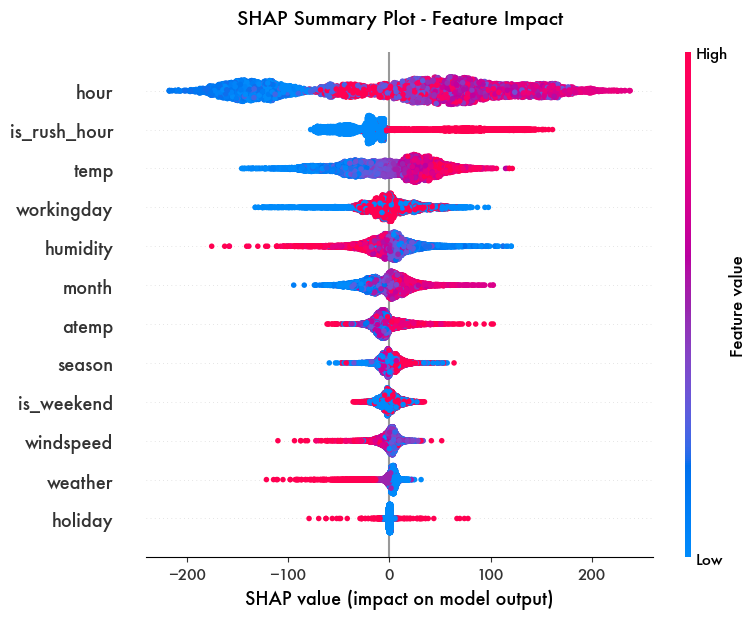

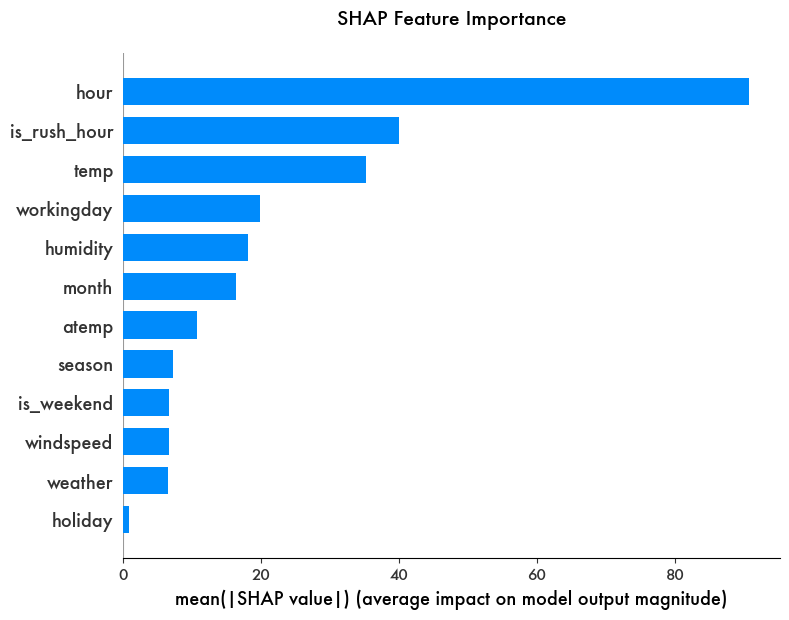


SHAP-based Feature Importance (Top 10):
     Feature  Mean_|SHAP|
        hour    90.729225
is_rush_hour    39.932858
        temp    35.208019
  workingday    19.818996
    humidity    18.054083
       month    16.340694
       atemp    10.644635
      season     7.232032
  is_weekend     6.680211
   windspeed     6.594430


In [24]:
# Explication via SHAP
    
# SHAP explainer
explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])
shap_values = explainer.shap_values(X_train)
    
# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train, show=False, max_display=15)
plt.title('SHAP Summary Plot - Feature Impact', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_train, plot_type="bar", show=False, max_display=15)
plt.title('SHAP Feature Importance', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Mean absolute SHAP values
mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance_df = pd.DataFrame({
'Feature': feature_cols,
'Mean_|SHAP|': mean_abs_shap
}).sort_values('Mean_|SHAP|', ascending=False)

print("\nSHAP-based Feature Importance (Top 10):")
print(shap_importance_df.head(10).to_string(index=False))

In [25]:
# Modélisation - Dignostic

print(f"Meilleur modèle actuel : {best_model_name}")
print(f"  R² en CV : {best_cv_r2:.4f} (±{best_cv_std:.4f})")
print(f"  Écart train/test : {best_gap:.4f}")

print("\n" + "-"*80)
print("DIAGNOSTIC :")
print("-"*80)

# Logique de diagnostic
if best_gap < 0.02 and best_cv_r2 < 0.75:
    print("✓ Statut : SOUS-APPRENTISSAGE (biais faible, variance faible)")
    print("  → Action : Augmenter la complexité du modèle")
    print("  → Essayer : Arbres plus profonds, plus d’estimateurs, features polynomiales")
    diagnosis = "underfit"
    
elif best_gap > 0.10:
    print("⚠  Statut : SUR-APPRENTISSAGE (variance élevée)")
    print("  → Action : Régulariser ou simplifier")
    print("  → Essayer : max_depth↓, min_samples_leaf↑, reg_alpha↑, early_stopping")
    diagnosis = "overfit"
    
elif best_cv_std > 0.03:
    print("⚠  Statut : VARIANCE ÉLEVÉE entre les folds")
    print("  → Action : Plus de données ou régularisation plus forte")
    print("  → Essayer : Augmenter la taille d’entraînement, bagging, CV imbriqué")
    diagnosis = "unstable"
    
else:
    print("Statut : BON ÉQUILIBRE")
    print(" → Action : Passer à l’optimisation des hyperparamètres")
    print(" → Essayer : RandomizedSearchCV pour affiner")
    diagnosis = "good"

Meilleur modèle actuel : XGBoost
  R² en CV : 0.8691 (±0.0033)
  Écart train/test : 0.0792

--------------------------------------------------------------------------------
DIAGNOSTIC :
--------------------------------------------------------------------------------
Statut : BON ÉQUILIBRE
 → Action : Passer à l’optimisation des hyperparamètres
 → Essayer : RandomizedSearchCV pour affiner


In [26]:
# Modélisation - Hyperparamtétrage

param_dist = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [3, 5, 7, 9],
    'model__learning_rate': [0.01, 0.05, 0.1],
    'model__subsample': [0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.01, 0.1],
    'model__reg_lambda': [0.1, 1, 10]
}

# RandomizedSearchCV
print(f"Recherche de {40} combinaisons...")
random_search = RandomizedSearchCV(
    models_config[best_model_name],
    param_distributions=param_dist,
    n_iter=40,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    random_state=1,
    verbose=1
)
    
random_search.fit(X_train, y_train)
    
print(f"\n✓ Hyperparamtétrage terminé!")
print(f"\nMeilleurs paramètres:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
    
print(f"\nMeilleur CV R²: {random_search.best_score_:.4f}")
print(f"Amelioration par rapport à la baseline: {(random_search.best_score_ - best_cv_r2)*100:+.2f}%")
    
# Update best pipeline
best_pipeline = random_search.best_estimator_
    
# Métriques
y_train_pred_tuned = best_pipeline.predict(X_train)
train_r2_tuned = r2_score(y_train, y_train_pred_tuned)
    
# Score CV
cv_r2_tuned = random_search.best_score_
gap_tuned = train_r2_tuned - cv_r2_tuned
    
print(f"\nPerformance:")
print(f"  Train R²: {train_r2_tuned:.4f}")
print(f"  CV R²: {cv_r2_tuned:.4f}")
print(f"  Gap: {gap_tuned:.4f}")
    
if gap_tuned < 0.05:
    print("  ✓ Bon équilibre - Prêt pour l'évaluation sur le jeu de test!")
else:
    print("  ⚠  Overfitting - Régularisation")

Recherche de 40 combinaisons...
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✓ Hyperparamtétrage terminé!

Meilleurs paramètres:
  model__subsample: 0.8
  model__reg_lambda: 0.1
  model__reg_alpha: 0
  model__n_estimators: 300
  model__max_depth: 7
  model__learning_rate: 0.05
  model__colsample_bytree: 1.0

Meilleur CV R²: 0.8765
Amelioration par rapport à la baseline: +0.74%

Performance:
  Train R²: 0.9605
  CV R²: 0.8765
  Gap: 0.0840
  ⚠  Overfitting - Régularisation


In [27]:
# Modélisation - Évaluation sur le jeu de test

# Prédiction
y_test_pred = best_pipeline.predict(X_test)

# Métriques
final_r2 = r2_score(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("\n" + "="*80)
print("PERFORMANCE FINAL")
print("="*80)
print(f"\nModèle: {best_model_name}")
print(f"\n  Test R²:   {final_r2:.4f}")
print(f"  Test MAE:  {final_mae:.2f} bikes")
print(f"  Test RMSE: {final_rmse:.2f} bikes")

# Compare to CV
print(f"\n" + "-"*80)
print("CV vs Test Comparison:")
print("-"*80)
if 'cv_r2_tuned' in locals():
    cv_final = cv_r2_tuned
else:
    cv_final = best_cv_r2

print(f"  CV R²:   {cv_final:.4f}")
print(f"  Test R²: {final_r2:.4f}")
print(f"  Difference: {abs(cv_final - final_r2):.4f}")

if abs(cv_final - final_r2) < 0.03:
    print("  ✓ Excellente généralisation!")
elif abs(cv_final - final_r2) < 0.05:
    print("  ✓ Bonne généralisation")
else:
    print("  ⚠ Différence Importante!")


PERFORMANCE FINAL

Modèle: XGBoost

  Test R²:   0.8883
  Test MAE:  41.49 bikes
  Test RMSE: 61.71 bikes

--------------------------------------------------------------------------------
CV vs Test Comparison:
--------------------------------------------------------------------------------
  CV R²:   0.8765
  Test R²: 0.8883
  Difference: 0.0118
  ✓ Excellente généralisation!


In [28]:
# Résumé et Recommandations

print(f"\nINSIGHTS:")
print(f"  • Effet de la Saison: {'Significant' if p_kw < 0.05 else 'Not significant'} (ε²={epsilon_squared:.4f})")
print(f"  • Effet de la Météo: {'Significant' if p_kw_weather < 0.05 else 'Not significant'} (ε²={epsilon_squared_weather:.4f})")
print(f"  • Heures de Pointe: {', '.join([f'{h}:00' for h in hourly_avg.nlargest(3).index])}")
print(f"  • Meilleure Saison: {df.groupby('season_label')['count'].mean().idxmax()}")

print(f"\nRECOMMENDATIONS:")
print(f"  1. Gestion de la flotte:")
print(f"     • Déployer {pct_diff:.0f}% de Vélos en plus les jours ouvrés" if p_mw < 0.05 else "      • Jour Ouvré a un effet minimal")
print(f"     • Augmenter la capacité durant les heures de pointe (7 et 9 heures du matin, 5 et 7 heure du soir)")
print(f"     • Ajustement selon la Météo")
print(f"  2. Stratégie de tarification:")
print(f"     • Tarification dynamique basée sur la demande prédite")
print(f"     • Tarif promotionnel durant les moments creux")


INSIGHTS:
  • Effet de la Saison: Significant (ε²=0.0640)
  • Effet de la Météo: Significant (ε²=0.0186)
  • Heures de Pointe: 17:00, 18:00, 8:00
  • Meilleure Saison: Fall

RECOMMENDATIONS:
  1. Gestion de la flotte:
      • Jour Ouvré a un effet minimal
     • Augmenter la capacité durant les heures de pointe (7 et 9 heures du matin, 5 et 7 heure du soir)
     • Ajustement selon la Météo
  2. Stratégie de tarification:
     • Tarification dynamique basée sur la demande prédite
     • Tarif promotionnel durant les moments creux
